In [1]:
# Standard libraries:
import os

# Third-party libraries:
from catboost import CatBoostClassifier
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

#import data
file_name = "bankrupt_data.csv"

In [2]:
# Save location of notebook:
notebook_dir = os.getcwd()
notebook_dir

'/Users/jeongjaehui/Documents/Stats_404/JEONG-JAEHEE'

In [3]:
# Path to repository on my machine:
bankrupt_dir = "/Users/jeongjaehui/Documents/Stats_404/JEONG-JAEHEE"

In [4]:
# **Step 3**: Change directories to the repository on your local machine:

os.chdir(bankrupt_dir)

In [5]:
# ### Step 3-b: Read-in Data
# Read-in the data using the panda
df = pd.read_csv('bankrupt_data.csv', encoding = 'latin-1')

In [6]:
#df = pd.read_csv(filepath_or_buffer = file_name, encoding = 'latin-1')

In [7]:
#check row and columns
df.shape

(6819, 96)

In [8]:
#check if there are missing values
df.info()
#There is no missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Bankrupt?                                                            6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest             6819 non-null   float64
 2    ROA(A) before interest and % after tax                              6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax                   6819 non-null   float64
 4    operating gross margin                                              6819 non-null   float64
 5    realized sales gross margin                                         6819 non-null   float64
 6    operating profit rate                                               6819 non-null   float64
 7    tax P

In [9]:
#remove space from columns

a = df.columns.tolist()
a = [x.strip(' ') for x in a]

df.columns = a

net income to total assets                                -0.315457
ROA(A) before interest and % after tax                    -0.282941
ROA(B) before interest and depreciation after tax         -0.273051
ROA(C) before interest and depreciation before interest   -0.260807
net worth/assets                                          -0.250161
                                                             ...   
current liabilities to current assets                      0.171306
borrowing dependency                                       0.176543
current liability to assets                                0.194494
equity to liability                                       -0.083048
debt ratio %                                               0.250161
Length: 95, dtype: float64


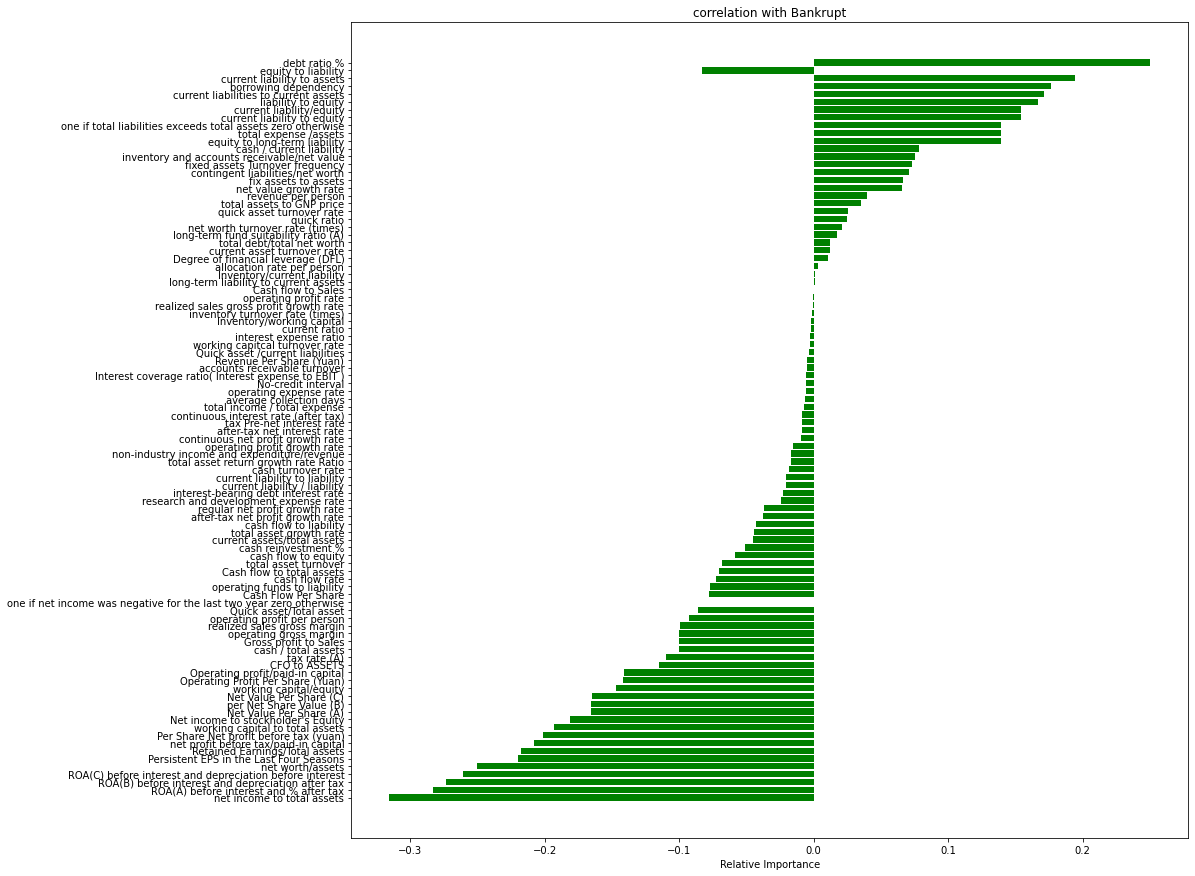

In [10]:
#Since we have too many features, we will select some features that are meaningful using one of the feature selection methods, filter method.

#step1. Remove the features that have a low correlation with the target value.

X = df.iloc[:,1:]
y = df['Bankrupt?']

importances = X.apply(lambda x:x.corr(y))
indices = np.argsort(importances)
print(importances[indices])

names= df.columns[1:]

plt.figure(figsize = (15, 15))

plt.title('correlation with Bankrupt')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [11]:
#We will save the features that have a correlation higher than the absolute value of 0.10. Therefore, I will set the treshold to the absolute value of 0.10.
a = []

for i in range(0, len(indices)):
    if np.abs(importances[i])>0.10:     
        a.append(names[i])
        print(names[i])

print(len(a))

X = df.loc[:, a]

ROA(C) before interest and depreciation before interest
ROA(A) before interest and % after tax
ROA(B) before interest and depreciation after tax
operating gross margin
tax rate (A)
per Net Share Value (B)
Net Value Per Share (A)
Net Value Per Share (C)
Persistent EPS in the Last Four Seasons
Operating Profit Per Share (Yuan)
Per Share Net profit before tax (yuan)
debt ratio %
net worth/assets
borrowing dependency
Operating profit/paid-in capital
net profit before tax/paid-in capital
working capital to total assets
cash / total assets
current liability to assets
working capital/equity
current liability/equity
Retained Earnings/Total assets
total expense /assets
current liability to equity
equity to long-term liability
CFO to ASSETS
current liabilities to current assets
one if total liabilities exceeds total assets zero otherwise
net income to total assets
Gross profit to Sales
Net income to stockholder's Equity
liability to equity
32


In [12]:
#Step2: Remove the features that have a correlation higher than 90% with other independent variables.

corr = X.corr()

columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                
selected_columns = X.columns[columns]

print(len(selected_columns))
#Now we only have 21 features. I will create a new df with these selected columns and the features that I think it's important.

new_df = pd.concat([df[['Bankrupt?', 'net income to total assets', 'Cash flow to total assets', 'tax Pre-net interest rate', 'inventory and accounts receivable/net value']],X[selected_columns]], axis=1)
print(new_df.columns)
print(new_df.shape)

#We have 25 features and target.

21
Index(['Bankrupt?', 'net income to total assets', 'Cash flow to total assets',
       'tax Pre-net interest rate',
       'inventory and accounts receivable/net value',
       'ROA(C) before interest and depreciation before interest',
       'operating gross margin', 'tax rate (A)', 'per Net Share Value (B)',
       'Persistent EPS in the Last Four Seasons',
       'Operating Profit Per Share (Yuan)', 'debt ratio %', 'net worth/assets',
       'borrowing dependency', 'working capital to total assets',
       'cash / total assets', 'current liability to assets',
       'working capital/equity', 'current liability/equity',
       'Retained Earnings/Total assets', 'total expense /assets',
       'equity to long-term liability', 'CFO to ASSETS',
       'current liabilities to current assets',
       'one if total liabilities exceeds total assets zero otherwise',
       'Net income to stockholder's Equity'],
      dtype='object')
(6819, 26)


In [13]:
#split the dataset into training and test sets

X = new_df.iloc[:,1:]
y = new_df['Bankrupt?']

#use K-fold function to split data. 80% of the data will be training set and the rest of it will be test set.
skf = StratifiedKFold(n_splits = 5, shuffle = False)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

TRAIN: [1104 1118 1132 ... 6816 6817 6818] TEST: [   0    1    2 ... 1383 1384 1385]
TRAIN: [   0    1    2 ... 6816 6817 6818] TEST: [1104 1118 1132 ... 2796 2797 2798]
TRAIN: [   0    1    2 ... 6816 6817 6818] TEST: [1860 1861 1862 ... 4136 4137 4138]
TRAIN: [   0    1    2 ... 6816 6817 6818] TEST: [2100 2147 2148 ... 5475 5476 5477]
TRAIN: [   0    1    2 ... 5475 5476 5477] TEST: [3749 3908 4071 ... 6816 6817 6818]


In [14]:
# Create dictionary of outcome variable labels, per repository:
label_dict = {
    0: "Stable",
    1: "Bankruptcy"
}

In [15]:
#check if the percentage of bankruptcy is similar between the train set and the test set 
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts = True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts = True)

print(train_counts_label/len(original_ytrain))
print(test_counts_label/len(original_ytest))

#The distribution of bankruptcy is similar to the original dataset.

[0.96774194 0.03225806]
[0.96771827 0.03228173]


In [16]:
#export a training set and a test set as csv
original_Xtrain.to_csv(r'C:\Users\jeongjaehui\Documents\Stats_404\JEONG-JAEHEE\bankrupt_training_set.csv', index = False, header=True)
original_Xtest.to_csv(r'C:\Users\jeongjaehui\Documents\Stats_404\JEONG-JAEHEE\bankrupt_test_set.csv', index = False, header=True)

In [17]:
original_Xtrain.shape

(5456, 25)

In [18]:
#splite the data into training and valiation sets


X_train, X_val, y_train, y_val = train_test_split(original_Xtrain, original_ytrain, test_size = 0.1, random_state = 1,stratify = original_ytrain, shuffle = True)

In [19]:

#generate a logistics regression model

log_reg = LogisticRegression(class_weight='balanced', max_iter=10000)
log_model = log_reg.fit(X_train, y_train)
log_pred = log_model.predict(X_val)



#check a classification
print(classification_report(y_val, log_pred))

print(pd.DataFrame(confusion_matrix(y_val, log_pred), columns = ['Predicted Nagative', 'Predicted Positive'], index = ['Actual Negative', 'Actual Positive']))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91       528
           1       0.16      0.94      0.27        18

    accuracy                           0.84       546
   macro avg       0.58      0.89      0.59       546
weighted avg       0.97      0.84      0.89       546

                 Predicted Nagative  Predicted Positive
Actual Negative                 439                  89
Actual Positive                   1                  17


In [20]:
log_pred = log_model.predict(original_Xtest)

#check a classification
print(classification_report(original_ytest, log_pred))

print(pd.DataFrame(confusion_matrix(original_ytest, log_pred), columns = ['Predicted Nagative', 'Predicted Positive'], index = ['Actual Negative', 'Actual Positive']))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1319
           1       0.26      0.89      0.41        44

    accuracy                           0.92      1363
   macro avg       0.63      0.90      0.68      1363
weighted avg       0.97      0.92      0.94      1363

                 Predicted Nagative  Predicted Positive
Actual Negative                1210                 109
Actual Positive                   5                  39


In [21]:
#check coefficient
log_model.coef_[0]

array([-5.98406132, -2.45399101,  0.2222234 , -1.04247674, -8.70014172,
       -0.29078314, -1.15978946, -2.953574  , -5.15546299, -1.7638457 ,
        6.62767905, -6.62453619,  1.33787312, -3.26018134, -4.80777621,
        0.77448516, -0.61847342, -0.09681221, -2.89645895, -0.50268511,
        1.16545371, -0.80870428,  1.23302969, -0.16283334, -0.32926271])

In [22]:
#fit the best model
cat = CatBoostClassifier(iterations=500,
                           loss_function='Logloss',
                           depth=6,
                           l2_leaf_reg=1e-20,
                           eval_metric='Accuracy',
                           leaf_estimation_iterations=10,
                           use_best_model=True,
                           logging_level='Silent',
                           random_seed=42,
                           class_weights = (1, 30)
                          )
                          
cat_model = cat.fit(X_train,y_train, eval_set = (X_val,y_val))


In [23]:
cat_pred = cat_model.predict(X_val)

In [24]:


print(classification_report(y_val, cat_pred))

#create a confusion matrix using the validation set
print(pd.DataFrame(confusion_matrix(y_val, cat_pred), columns = ['Predicted Nagative', 'Predicted Positive'], index = ['Actual Negative', 'Actual Positive']))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93       528
           1       0.19      0.89      0.31        18

    accuracy                           0.87       546
   macro avg       0.59      0.88      0.62       546
weighted avg       0.97      0.87      0.91       546

                 Predicted Nagative  Predicted Positive
Actual Negative                 460                  68
Actual Positive                   2                  16


In [25]:
cat_pred = cat_model.predict(original_Xtest)

print(classification_report(original_ytest, cat_pred))

#create a confusion matrix using the validation set
print(pd.DataFrame(confusion_matrix(original_ytest, cat_pred), columns = ['Predicted Nagative', 'Predicted Positive'], index = ['Actual Negative', 'Actual Positive']))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1319
           1       0.26      0.84      0.39        44

    accuracy                           0.92      1363
   macro avg       0.62      0.88      0.67      1363
weighted avg       0.97      0.92      0.94      1363

                 Predicted Nagative  Predicted Positive
Actual Negative                1211                 108
Actual Positive                   7                  37


(0.0, 1.0)

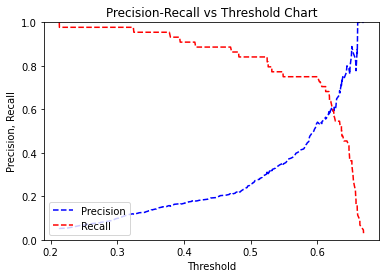

In [26]:
#generate a precision recall curve to check if we can change the threshold to increase FalseNegative.

probs = cat_model.predict_proba(original_Xtest)
positive_probs = probs[:, 1]


precision, recall, thresholds = precision_recall_curve(original_ytest, positive_probs) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


In [28]:
THRESHOLD = 0.37
thre_37_preds_cat = np.where(cat_model.predict_proba(X_val)[:,1] > THRESHOLD, 1, 0)

#check a classification
print(classification_report(y_val, thre_37_preds_cat))

print(pd.DataFrame(confusion_matrix(y_val, thre_37_preds_cat), columns = ['Predicted Nagative', 'Predicted Positive'], index = ['Actual Negative', 'Actual Positive']))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       528
           1       0.10      0.94      0.18        18

    accuracy                           0.72       546
   macro avg       0.55      0.83      0.50       546
weighted avg       0.97      0.72      0.81       546

                 Predicted Nagative  Predicted Positive
Actual Negative                 374                 154
Actual Positive                   1                  17


In [29]:
thre_37_preds_cat = np.where(cat_model.predict_proba(original_Xtest)[:,1] > THRESHOLD, 1, 0)

#check a classification
print(classification_report(original_ytest, thre_37_preds_cat))

print(pd.DataFrame(confusion_matrix(original_ytest, thre_37_preds_cat), columns = ['Predicted Negative', 'Predicted Positive'], index = ['Actual Negative', 'Actual Positive']))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      1319
           1       0.15      0.95      0.26        44

    accuracy                           0.83      1363
   macro avg       0.58      0.89      0.58      1363
weighted avg       0.97      0.83      0.88      1363

                 Predicted Negative  Predicted Positive
Actual Negative                1085                 234
Actual Positive                   2                  42


In [30]:
#check features' importance of this model
feat_imp_cat = cat_model.get_feature_importance(prettified=True)

important_features = feat_imp_cat.loc[feat_imp_cat['Importances'] > 0]
#important_features[0] = important_features[0].iloc[:,0]

important_features

,Feature Id,Importances
0,net income to total assets,10.974931
1,ROA(C) before interest and depreciation before...,10.602950
2,tax rate (A),9.431715
3,borrowing dependency,7.735259
4,per Net Share Value (B),6.955354
5,current liability to assets,6.548995
6,debt ratio %,6.199320
7,Net income to stockholder's Equity,5.740637
8,net worth/assets,4.674117
9,total expense /assets,3.959321
